# Reto
**Diego Reyna Reyes A0167387**


En este notebook se buscará probar que bots suelen tener una interacción considerable con figuras políticas.

Para lo lograr identificar lo usuarios que tienen una mayor posibilidad de ser bots, me basaré en el [Notebook realizado por HANNAH SUN](https://www.kaggle.com/code/hannahsuny/botnot-project).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import preprocessing
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
!pip install wordcloud
from wordcloud import WordCloud

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Lectura de los datos

Se obtienen los datos del archivo *covid19_tweets.csv*

In [2]:
dataframe = pd.read_csv(r"covid19_tweets.csv")
dataframe.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [3]:
dataframe.tail()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
74431,Laura Wolfrom,"Lexington, KY",The only things I collect are memories.,2010-09-24 02:01:15,85,586,1902,False,2020-08-04 03:13:29,So far this summer I have filled up my lawn mo...,"['COVID19', 'QuarantineLife']",Twitter for iPhone,False
74432,Professor Tonya M. Evans,😷 #stayathome,Law Prof @DickinsonLaw & Entrepreneur | Crypto...,2013-05-14 20:15:24,4289,1066,53569,False,2020-08-04 03:13:26,"ICYMI: REPLAY: #TechIntersect🧩 #16: Isaiah ""@B...","['TechIntersect', 'Bitcoin', 'COVID19']",Twitter Web App,False
74433,People's Daily app,"北京, 中华人民共和国",Our mission is to provide news and perspective...,2018-02-04 12:36:42,1413,102,16,False,2020-08-04 03:13:22,Community workers in Tianshan District of Urum...,"['China', 'Xinjiang']",Twitter Web App,False
74434,M0ser,NaN,Reagan conservative and attorney raised in the...,2014-02-18 03:46:28,2554,1733,129104,False,2020-08-04 03:13:19,If only we had a responsible media to warn us ...,['COVID19'],Twitter for iPhone,False
74435,Your Friend & Sabre ⚔️,"Chicago, IL",My spectral decomposition has a significant da...,2016-12-19 19:55:00,310,1748,60133,False,2020-08-04 03:13:15,MAGA: #COVID19 is just a cold &amp; it'd be go...,"['COVID19', 'Hydroxycholoroquine']",Twitter for Android,False


## Detección de posibles bots

El primer parámetro para detectar bots, se tomará en cuenta el tiempo entre la creación de la cuenta y su primera publicación.

Para lograr esto, se extraen los datos de las columnas *user_created* y *date*

In [4]:
dataframe['account_creation_date'] = dataframe['user_created'].str.slice(0, 10)
dataframe['account_creation_date'] = dataframe['account_creation_date'].replace(
    '-', '', regex=True).astype(str)
dataframe.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,account_creation_date
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,20170526
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,20090416
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,20090228
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,20190307
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,20170212


In [5]:
dataframe['pub_date'] = dataframe['date'].str.slice(0, 10)
dataframe['pub_date'] = dataframe['pub_date'].replace(
    '-', '', regex=True).astype(str)
dataframe.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,account_creation_date,pub_date
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,20170526,20200725
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,20090416,20200725
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,20090228,20200725
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,20190307,20200725
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,20170212,20200725


Tras extraer las fechas, se realiza la resta de ambos valores y se encuentra el valor menor para cada cuenta incluida en nuestro dataset

In [6]:
dataframe["time_create_pub"] = dataframe["pub_date"].astype(int) - dataframe["account_creation_date"].astype(int)
df2_full = dataframe.sort_values(by = "time_create_pub").copy()
df2 = dataframe.groupby("user_name")
df2 = df2.time_create_pub.min()
df2 = pd.DataFrame(df2).sort_values(by = "time_create_pub")
df2.loc[df2['time_create_pub'] > 150000, 'time_create_pub'] = 150000 #Eliminar casos de fechas registradas antes de la creación de twitter

Otro de los parámetros a utilizar es la relación entre usuarios seguidos y seguidores, esto, de acuerdo con lo estipulado con el Notebook mencionado en la introducción; el fundamento viene de que muchas cuentas de bots son utilizadas para seguir a otros bots o a alguena cuenta objetivo.

In [7]:
df3 = dataframe.copy()
df3['follow_ratio'] = df3["user_friends"]/df3["user_followers"]
df3.loc[np.isnan(df3['follow_ratio']), 'follow_ratio'] = 0
df3.loc[np.isinf(df3['follow_ratio']), 'follow_ratio'] = 0
df3 = df3.groupby("user_name")
df3 = df3.follow_ratio.min()
df3 = pd.DataFrame(df3)
user_data = pd.merge(df2,df3, on = ['user_name'])


Otro parámetro a utilizar es el número de hastags utilizados, ya que el uso de muchos hashtags puede indicar que se busca que la publicación tenga un mayor alcance, que es parte del objetivo de los bots.

In [8]:
#Encuentra el número de hastags en el texto
def find_hash(text):
  s = ".*"
  has = 0
  temp = re.compile(s)
  #Forma de identificar si el texto es Nan obtenida de:
  #https://www.codespeedy.com/check-if-a-given-string-is-nan-in-python/
  if not text != text:
    for word in text.split(" "):
        a = temp.findall(word)
        if a != []:
            has += 1
  return has

In [9]:
df4 = dataframe.copy()
df4['n_hashtag'] = df4['hashtags'].apply(find_hash)
df4 = df4.groupby("user_name")
df4 = df4.n_hashtag.mean()
df4 = pd.DataFrame(df4)
user_data = pd.merge(user_data,df4, on = ['user_name'])

Nuestro parámettro final es la presencia de una descripción de usuario, ya que la falta de esta, puede indicar que la cuenta no corresponde a un usuario.

In [10]:
df5 = dataframe.copy()
df5.loc[df5['user_description'] != df5['user_description'], 'has_description'] = 0
df5.loc[df5['user_description'] == df5['user_description'], 'has_description'] = 1
df5 = df5.groupby("user_name")
df5 = df5.has_description.mean()
df5 = pd.DataFrame(df5)
user_data = pd.merge(user_data,df5, on = ['user_name'])

### Visualización de los datos obtenidos

array([[<Axes: title={'center': 'time_create_pub'}>,
        <Axes: title={'center': 'follow_ratio'}>],
       [<Axes: title={'center': 'n_hashtag'}>,
        <Axes: title={'center': 'has_description'}>]], dtype=object)

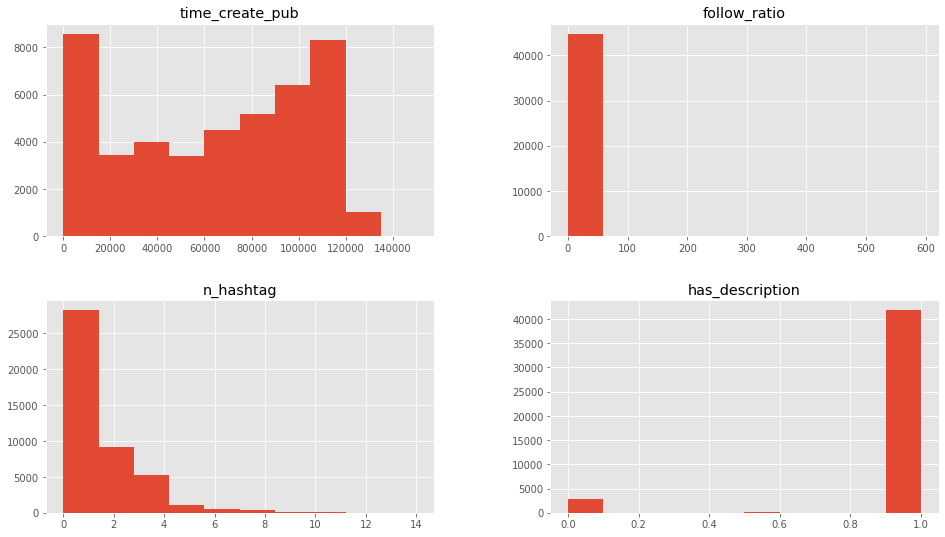

In [11]:
user_data.hist()

### Normalización de los datos
Tras haber obtenido los datos, se normalizan a un rango \[0-1\], esto con el objetivo que los 4 parámetros estén en el mismo rango y su contribución a la probabilidad esté completamente definida por los pesos que se le asignen

In [12]:
scaler = MinMaxScaler()
scaler.fit(user_data[['time_create_pub','follow_ratio','n_hashtag','has_description']])
user_data[['time_create_pub','follow_ratio','n_hashtag','has_description']] = scaler.transform(user_data[['time_create_pub','follow_ratio','n_hashtag','has_description']])


Se asignaron los siguientes pesos:

*time_created_pub* - 2

*follow_ratio* - 1

*n_hashtag* - 1

*has_description* - 1

Para poder obtener un puntaje, el tiempo de creación será restado a 1, debido a que si este tiempo es menor, aumenta la probabilidad de que el usuario se trate de un bot. Paralelamente, el valor de *has_description* está negado para que aquellos usuarios sin descripción tengan una probabilidad mayor. 

<Axes: >

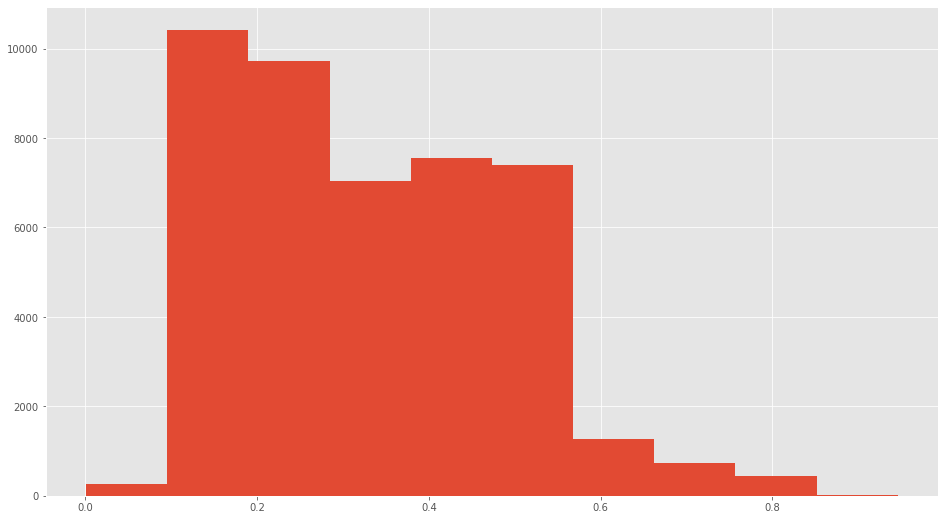

In [13]:
w = [2,1,1,1]
max_probability = 1 * w[0] + 1 * w[1] + 1 * w[2] + 0 * w[3]
user_data["bot_probability"] = ((1 - user_data["time_create_pub"]) * w[0] + user_data["follow_ratio"] * w[1] + user_data["n_hashtag"] * w[2] + (1 - user_data["has_description"]) * w[3])/max_probability
user_data["bot_probability"].hist()

### Selección de posibles bots

Se seleccionaron aquellos usuarios con una probabilidad mayor al 60\% de ser bots.

<Axes: >

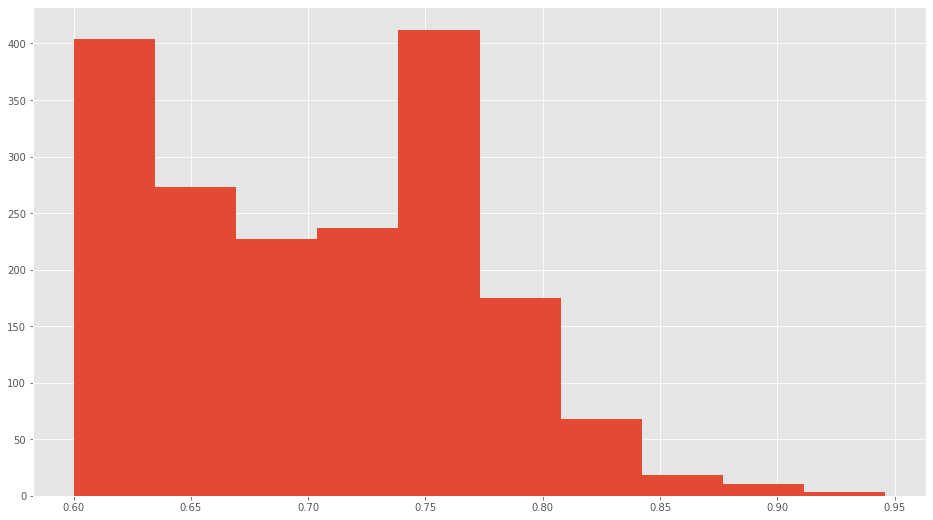

In [14]:
possible_bot = user_data[user_data["bot_probability"] > 0.6]
possible_bot["bot_probability"].hist()

## Análisis de las publicaciones

Se mantienen solamente aquellas publicaciones de los usuarios sospechosos

In [15]:
bot_tweets = pd.merge(possible_bot,dataframe.copy(), on='user_name')

## Generación de nube de palabras
Como parte del análisis, se realiza una nube de palabras para todas las publicaciones registradas, y todas aquellas realizadas por los usuarios sospechosos, con el objetivo de ver si hay una diferencia significativa a simple vista.

Estas nubes de palabras son creadas con base en el tutorial de [datanizing GmbH](https://medium.com/@datanizing/modern-text-mining-with-python-part-2-of-5-data-exploration-with-pandas-ee3456cf6a4) y el código proporcionado por Sergio Ruíz 

In [16]:
def text_cleaner(text):
    text = re.sub(r"\n"," ", str(text)) 
    text = re.sub (r"\t"," ", str(text))
    text = re.sub (r"\r", " ", str(text))
    text = re.sub(r"(@)|(#)|(RT[\s]+)|(https?:\/\/\S+)|([^a-zA-Z0-9 -])", " ", str(text))
    text = text.strip(" ")
    return text


In [17]:
def wordclouder(string_column, name):
    Words = ''.join([words for words in string_column])
    wordcloud = WordCloud (width=1000, height = 600, random_state = 10, background_color="white", max_words = 200)
    wordcloud.generate(Words)
    plt.style.use('fivethirtyeight')
    plt.figure(figsize = (20,28))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    wordcloud.to_file(name)
    plt.show()


### Nube de palabras para todos los registros

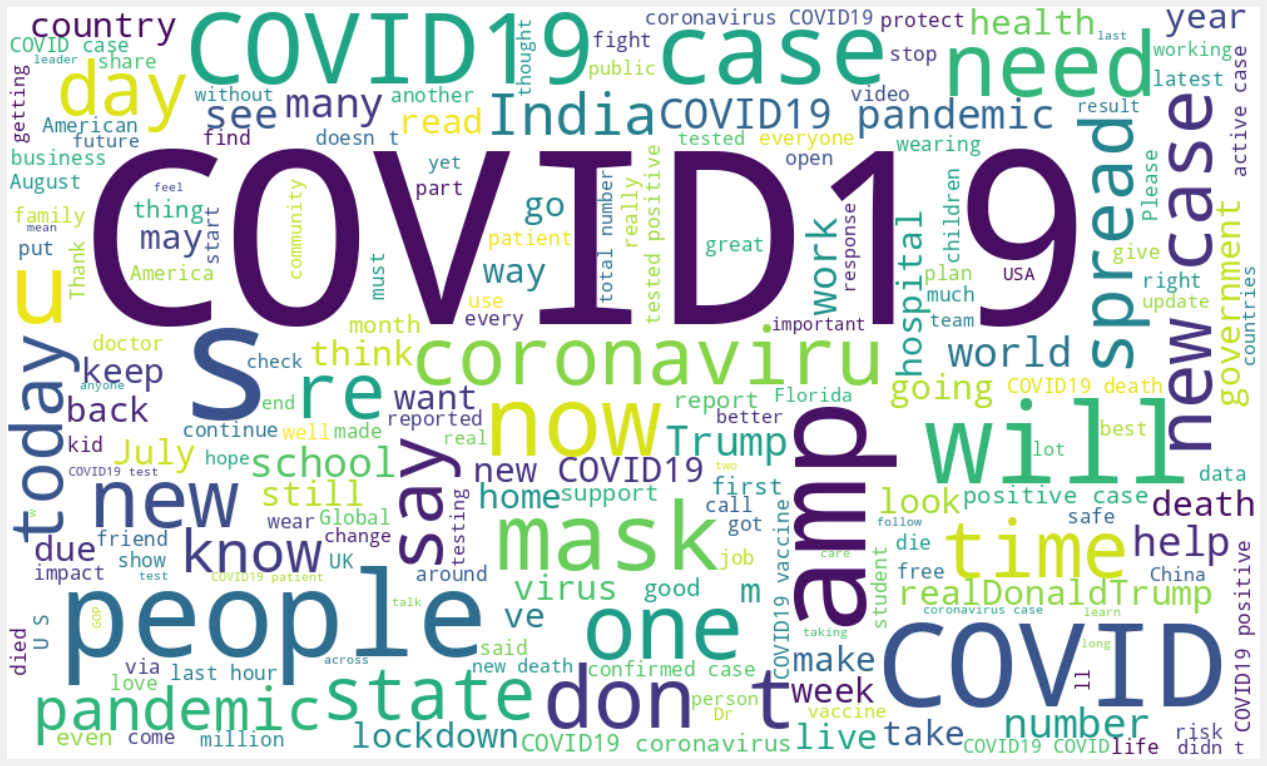

In [18]:
dataframe['text'] = dataframe['text'].apply(text_cleaner)
wordclouder(dataframe['text'], "tweets.png")


### Nube de palabras para las publicaciones de los usuarios sospechosos

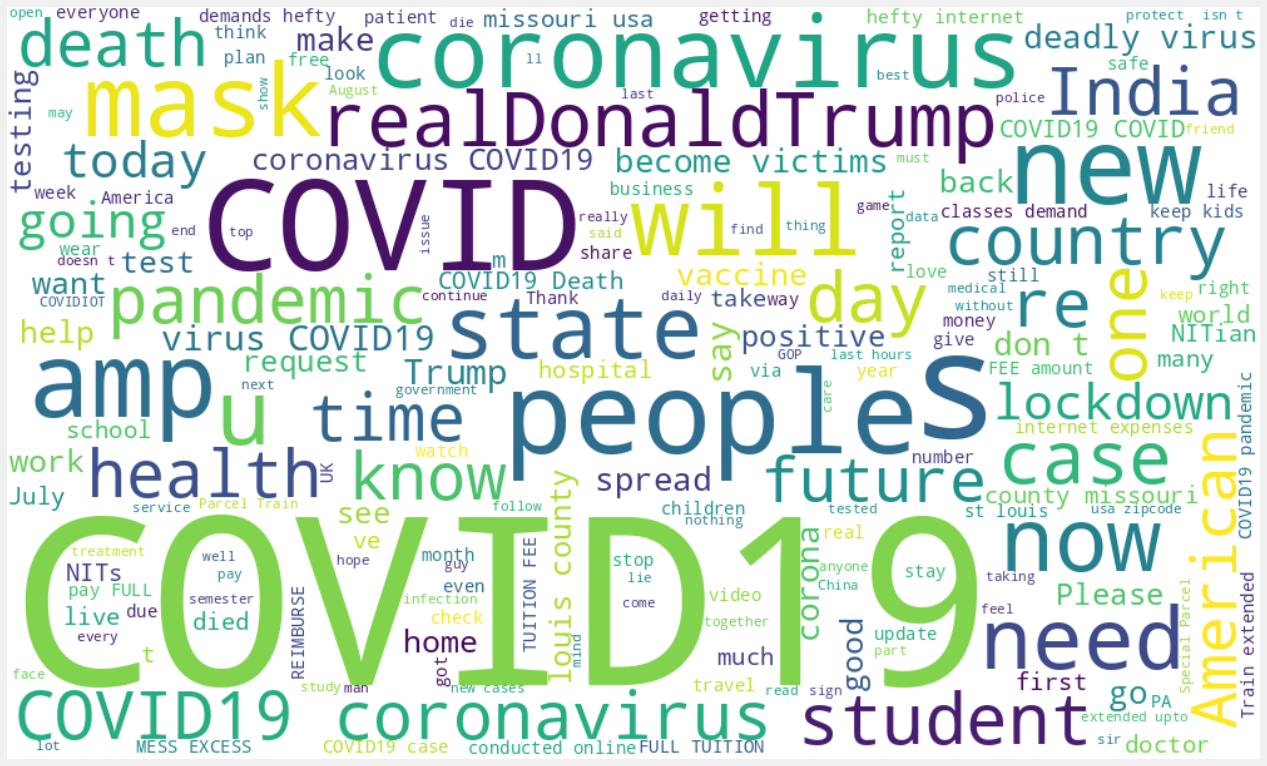

In [19]:
bot_tweets['text_clean'] = bot_tweets['text'].apply(text_cleaner)
wordclouder(bot_tweets['text_clean'], "tweets_bot.png")

## Detección de menciones

Para comprobar la interacción entre los usuarios sospechosos y figuras políticas, se encontrarán las menciones que realizan estos usuarios

In [20]:
#Extrae las menciones dentro de un texto y regresa un string con los usuarios mencionados
def find_at(text):
  s = "@.*"
  att = ""
  temp = re.compile(s)
  for word in text.split(" "):
      a = temp.findall(word)
      if a != []:
          att += " " + a[0]
  return att


### Visuzalización de las menciones

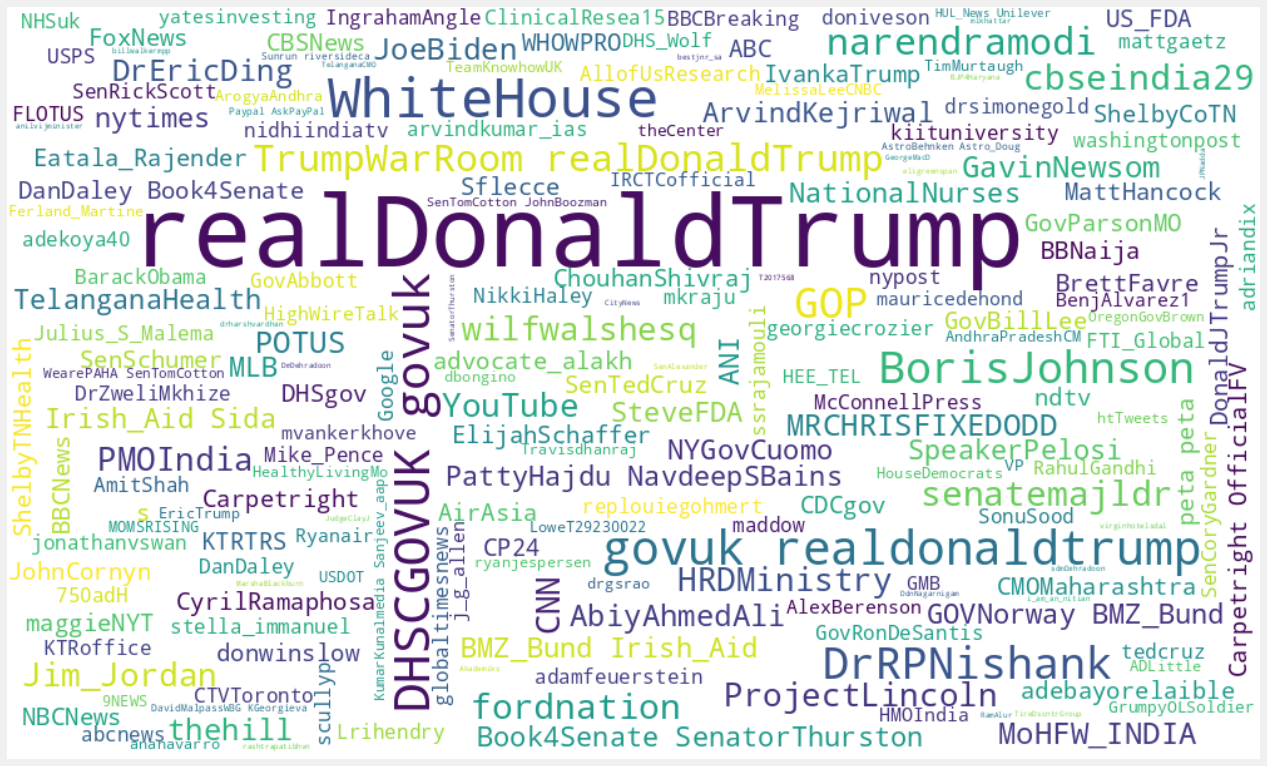

In [21]:
bot_tweets['at'] = bot_tweets['text'].apply(find_at)

wordclouder(bot_tweets['at'], "tweets_bot_at.png")

### Obtención y contabilización de las menciones

In [22]:
#Extrae las menciones del texto obtenido por la función text_cleaner(find_at(text))
def get_mentions(text):
  mentions = []
  for word in text.split(" "):
      mentions.append(word.lower())
  return mentions

In [23]:
mentions = bot_tweets
mentions['at_clean'] = bot_tweets['at'].apply(text_cleaner)

In [24]:
mentioned = pd.DataFrame(columns = ['user_name', 'mentions'])

for text in mentions['at_clean']:
  for m in get_mentions(text):
    if m != "":
      temp = pd.DataFrame({'user_name' : m, 'mentions' : 0}, index = [0])
      mentioned = pd.concat([mentioned, temp], ignore_index = True)
mentioned = mentioned.groupby("user_name")
mentioned = mentioned.user_name.count()
mentioned = pd.DataFrame({'user_name':mentioned.index, 'count':mentioned.values})
#Ordenar por vnumero de menciones
mentioned = mentioned.sort_values(by = "count", ascending = False)
mentioned = mentioned.reset_index()
mentioned.head()

,index,user_name,count
0,753,realdonaldtrump,173
1,996,who,20
2,995,whitehouse,18
3,254,dhscgovuk,15
4,384,govuk,15


In [25]:
#Se obtiene en términos de porcentaje del total de las menciones realizadas por los usuarios
total_mentions = sum(mentioned["count"])
mentioned["percentage"] = mentioned["count"] / total_mentions * 100
mentioned.head(20)

,index,user_name,count,percentage
0,753,realdonaldtrump,173,10.353082
1,996,who,20,1.196888
2,995,whitehouse,18,1.077199
3,254,dhscgovuk,15,0.897666
4,384,govuk,15,0.897666
5,123,borisjohnson,11,0.658288
6,283,drrpnishank,11,0.658288
7,373,gop,10,0.598444
8,792,s,9,0.538600
9,941,trumpwarroom,8,0.478755


### Resultados

De las menciones encontradas, se busca encontrar que al menos el 30% están relacionadas a una figura política, por lo que se realizó una lista de las menciones más populares que no son políticos. Esta identificación fue realizada manualmente debido a las limitaciones de tiempo, ya que, si se continuara desarrollando este reto, se haría un análisis de la biografía de los usuarios mencionados para determinar si se tratan de figuras políticas

In [26]:
not_politician = ["who", "cbseindia29", "carpetright", "cnn", "jim", "youtube", "wilfwalshesq", "jordan", "projectlincoln", "mohfw","india","thehill","s","mrchrisfixedodd","news",
                  "drericding","nytimes","bmz","nationalnurses","peta","irish","bund","ani","cp24","sida","mlb","cdcgov","alakh","abc","cbsnews",
                  "rajender","maggienyt","donwinslow","bbcnews","bbnaija","foxnews","eatala","elijahschaffer","fda","whowpro","officialfv",
                  "us","ndtv","airasia","nbcnews","dhsgov","shelbycotn","shelbytnhealth","brettfavre","ryanair","ryanjespersen","ssrajamouli",
                  "davidmalpasswbg","doniveson","dbongino","clinicalresea15","dhs","sanjeev","drgsrao","ctvtoronto","com","doug","drsimonegold",
                  "riversideca","ferland","irctcofficial","j","nidhiindiatv","nhsuk","jonathanvswan","mvankerkhove","kenya","kgeorgieva",
                  "kiituniversity","momsrising","kumarkunalmedia","mkraju","mike","melissaleecnbc","mauricedehond","malema","ingrahamangle",
                  "nypost","immanuel","police","fti","gc","global","globaltimesnews","gmb","google","ias","grumpyolsoldier","mcconnellpress",
                  "paypal","healthylivingmo","hee","highwiretalk","httweets","hul","stella","astro","wolf","wearepaha","bbcbreaking","usdot",
                  "usps","travisdhanraj","abcnews","adlittle","teamknowhowuk","allofusresearch","thecenter","tel","adamfeuerstein","ananavarro",
                  "washingtonpost","aap","alexberenson","sunrun","unilever","9news","750adh","yatesinvesting","astrobehnken","arogyaandhra","askpaypal",
                  "arvindkumar","allen","okcupid","no1hollyfreedom","npr","nta","officialwmas","officialnairam1","vfl2013","okdemocrats","odishafs","virusesimmunity",
                  "nycmcu","nychealthsystem","virginhotelsdal","nydnsports","oliveira1","vinquisition","viejobartender","vidushinegi2","viciedo",
                  "oc","odisha","nycaudubon","nyc","oldschool1000","oren","omnivistech","pedro53942070","urocklive1","urbandalecsd","petehegseth",
                  "pewresearch","pfizer","phe","pj","peacehealth","pk63","pkgman60","pleadiancrystal","unicefindia","unesco","umar","pearl",
                  "pdchinese","vanonselenp","opindia","veritasvital","veracityseeker3","osborn","otvnews","pdchina","oxforddiplomat"]
counted = 0
i = 0
top_mention = pd.DataFrame(columns = ["user_name","percentage"])
#Obtener los usuarios necesarios para tener el 30%
while counted < 30 or i == len(mentioned["user_name"]):
  if mentioned["user_name"][i] not in not_politician:
    counted += mentioned["percentage"][i]
    temp = pd.DataFrame({'user_name' : mentioned["user_name"][i], 'percentage' : mentioned["percentage"][i]}, index = [0])
    top_mention = pd.concat([top_mention, temp], ignore_index = True)
  i += 1
top_mention = top_mention.set_index("user_name")
print("Porcentaje estimado de menciones relacionadas a figuras políticas: {0:.2f}%".format(counted))

Porcentaje estimado de menciones relacionadas a figuras políticas: 30.04%


### Generación de gráfica de menciones

<Axes: ylabel='percentage'>

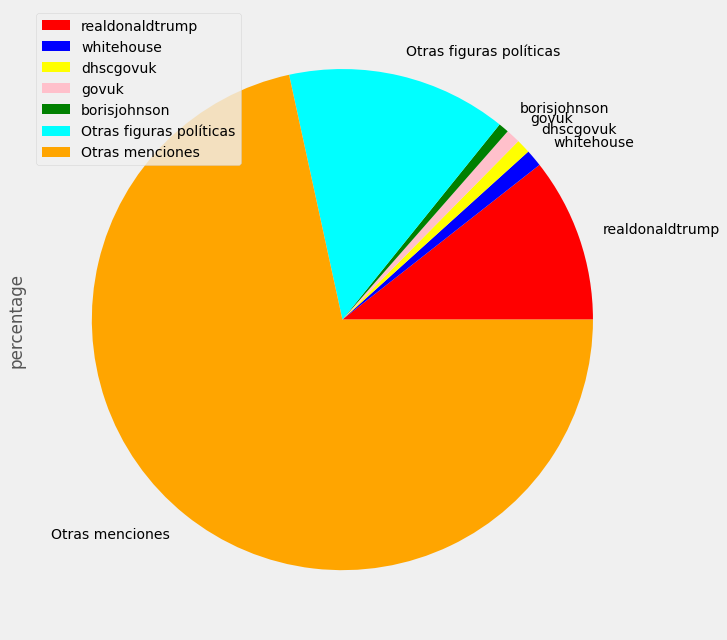

In [28]:
n = 5
temp = top_mention[0:n].copy()
t = pd.DataFrame({'user_name' : "Otras figuras políticas", 'percentage' : top_mention["percentage"][:n].sum()}, index = [0])
t = t.set_index("user_name")
temp = pd.concat([temp, t])
t = pd.DataFrame({'user_name' : "Otras menciones", 'percentage' : 100 - top_mention["percentage"].sum()}, index = [0])
t = t.set_index("user_name")
temp = pd.concat([temp, t])

temp.plot.pie(y = "percentage", figsize = (10,30), colors=["red", "blue", "yellow", "pink", "green", "cyan", "orange"])

## Conclusiones

Como se puede observar, se obtuvo el porcentaje de figuras políticas mencionadas deseado (30%), sin embargo, cabe destacar que dicho análisis muestra personalidades políticas de todo el mundo, con una principal participación de figuras políticas de los EE.UU, lo que puede indicar una alta incidencia de bots en las políticas de dicho país. Esta información podría utilizarse en futuras aplicaciones para realizar un estudio más avanzado, en el que se tomen en cuenta el origen de dicha cuentas para aumentar o disminuir su posibilidad de ser un bot.

### ¿Es posible incluir el uso del algoritmo Kmeans para apoyar con la descripción de los datos?

Para obtener los resultados deseados no es necesario, ya que su escenario de uso estaría relacionado a la identificación de que usuarios son figuras políticas, se podría hacer un análisis del nombre de usuario y los contenidos de la biografía para determinar usuarios similares, que al determinar aquellos parecidos a un usuario previamente identificado como político, se pueden obtener usuarios similares a políticos. Sin embargo, debido a que el análisis buscado es en el número de menciones de usuarios y no en agruparlos, el análisis kmeans no resulta de utilidad para el alcance de esta actividad, ya que su función sería principalmente la de optimización y automatización de la identificación de usuarios.

### Herramientas vistas durante el curso

#### Regresión lineal

Debido a que no se quieren realizar predicciones de nuevos datos, esta herramientas no fue utilizada, ya que esta es su función principal

#### Carga de datos con Python/Pandas

Esta herramienta fue utilizada para cargar los datos

#### Visualización de estadística básica

De las herramientas vistas en esta sección, se utilizó el histograma, ya que nos permite ver la distribución de los datos extrapolados de los provistos por el dataset, al igual que se utilizó el diagrama de pastel para poder visualizar los resultados. El diagrama de bigotes no fue utilizado debido a que se considera que no es necesario definir los cuartiles de la probabilidad para definir que procentaje usar, ya que no se sabe que porcentaje de los usuarios serían bots.